# Notebook 1: Numerical Implementation of a 1D LNS Solver

**Series:** Re-evaluating Fluid Dynamics: From Navier-Stokes Idealizations to Local Reality

## Introduction
Following the theoretical groundwork laid in Notebooks 0a-0c, this notebook transitions to the practical implementation of a solver for a simplified Local Navier-Stokes (LNS) system. We will focus on a 1D compressible flow scenario to illustrate the core numerical techniques. The primary goals are:
1.  Define the 1D LNS system equations and state vector.
2.  Implement functions for flux and source term calculations.
3.  Develop a Finite Volume Method (FVM) solver using a basic numerical flux (e.g., Lax-Friedrichs) and explicit time stepping.
4.  Test the solver with a canonical problem, such as the propagation of a thermal pulse, to observe wave-like behavior due to finite relaxation times.

This implementation will serve as a foundation for understanding the numerical challenges and characteristics of LNS systems before considering more complex 2D/3D scenarios or advanced numerical schemes.

## 1. Simplified 1D LNS System Definition

We consider a 1D flow in the $x$-direction. To keep the initial implementation manageable, we'll model a system including mass, x-momentum, total energy, and a single dynamically relaxing heat flux component $q_x$. Viscous stresses will be omitted in this first pass, or assumed to be handled by a simple Newtonian term if desired (though this would reintroduce a parabolic element unless that stress also relaxes).

**State Vector $\mathbf{Q}$ in 1D (4 variables):**
$$\mathbf{Q} = [\rho, m_x, E_T, q_x]^T$$
where $m_x = \rho u_x$ is the x-momentum density.

**1D LNS Equations (MCV heat flux, no viscous stress):**
1.  **Mass Conservation:**
    $$\frac{\partial \rho}{\partial t} + \frac{\partial (\rho u_x)}{\partial x} = 0 \implies \frac{\partial \rho}{\partial t} + \frac{\partial m_x}{\partial x} = 0$$
2.  **Momentum Conservation:**
    $$\frac{\partial m_x}{\partial t} + \frac{\partial (m_x u_x + p)}{\partial x} = 0$$
3.  **Total Energy Conservation:**
    $$\frac{\partial E_T}{\partial t} + \frac{\partial ((E_T + p)u_x + q_x)}{\partial x} = 0$$
4.  **Heat Flux Evolution (MCV, simplified 1D form):**
    We write this as $\frac{\partial q_x}{\partial t} + \frac{\partial (u_x q_x)}{\partial x} = S_{q_x}$, where the source term $S_{q_x}$ includes the relaxation part and potentially other terms from the objective derivative if it's more complex than just material advection.
    $$\frac{\partial q_x}{\partial t} + \frac{\partial (u_x q_x)}{\partial x} = -\frac{1}{\tau_q} \left( q_x + k \frac{\partial T}{\partial x} \right) + q_x \frac{\partial u_x}{\partial x}$$
    The last term $q_x \frac{\partial u_x}{\partial x}$ comes from $\nabla \cdot (\mathbf{u}A_k) = (\mathbf{u} \cdot \nabla)A_k + A_k (\nabla \cdot \mathbf{u})$. If the objective derivative used for MCV was just the material derivative $DA_k/Dt = \partial A_k/\partial t + (\mathbf{u} \cdot \nabla)A_k$, then $S_{q_x}$ simplifies.

**Flux Vector $\mathbf{F}(\mathbf{Q})$:**
$$\mathbf{F}(\mathbf{Q}) = \begin{bmatrix} m_x \\ m_x u_x + p \\ (E_T + p)u_x + q_x \\ u_x q_x \end{bmatrix}$$

**Source Vector $\mathbf{S}(\mathbf{Q})$:**
$$\mathbf{S}(\mathbf{Q}) = \begin{bmatrix} 0 \\ 0 \\ 0 \\ -\frac{1}{\tau_q} (q_x + k \frac{\partial T}{\partial x}) + q_x \frac{\partial u_x}{\partial x} \end{bmatrix}$$

**Primitive Variables & EOS:**
We need to convert $\mathbf{Q}$ to primitive variables $(\rho, u_x, p, T)$ to compute fluxes and source terms. Assume ideal gas: $p = \rho R T$, $E_T = \rho c_v T + \frac{1}{2} \rho u_x^2$, $c_v = R/(\gamma-1)$.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- Global Fluid & LNS Parameters ---
GAMMA = 1.4  # Ratio of specific heats
R_GAS = 287.0  # Specific gas constant (J/kgK) for air
CV_GAS = R_GAS / (GAMMA - 1.0) # Specific heat at constant volume

K_THERM = 0.026 # Thermal conductivity (W/mK) - can be tuned
TAU_Q = 1e-5    # Thermal relaxation time (s) - CRUCIAL PARAMETER
                # If TAU_Q is too small, source term becomes very stiff.
                # If TAU_Q is very large, q_x relaxes slowly.

NUM_VARS_1D = 4 # rho, m_x, E_T, q_x

# --- Variable Conversions ---
def Q_to_P_1D(Q_vec):
    """Conserved Q = [rho, m_x, E_T, q_x] to Primitive P = [rho, u_x, p, T]."""
    rho = Q_vec[0]
    if rho < 1e-9: # Density floor for stability
        rho = 1e-9
        # Return a default low energy state to prevent NaNs
        # This indicates potential issues if hit frequently
        return np.array([rho, 0.0, 1e-3*R_GAS*1.0, 1.0]) 
        
    m_x = Q_vec[1]
    E_T = Q_vec[2]
    # q_x = Q_vec[3] # q_x is also a primitive variable in this context

    u_x = m_x / rho
    e_int_rho = E_T - 0.5 * m_x * u_x # rho * e_i
    e_int = e_int_rho / rho 
    
    if e_int < 1e-9: # Internal energy floor
        e_int = 1e-9
        # Recalculate E_T based on floored e_int to maintain consistency for pressure calc
        # This can be tricky; better to ensure e_int stays positive via robust numerics

    T = e_int / CV_GAS
    p = rho * R_GAS * T
    
    return np.array([rho, u_x, p, T])

def P_and_q_to_Q_1D(rho, u_x, p, T, q_x):
    """Primitive P = [rho, u_x, p, T] and q_x to Conserved Q."""
    m_x = rho * u_x
    e_int = CV_GAS * T
    E_T = rho * e_int + 0.5 * rho * u_x**2
    return np.array([rho, m_x, E_T, q_x])

# --- Flux and Source Term Functions ---
def flux_1D_LNS(Q_vec):
    P_vec = Q_to_P_1D(Q_vec)
    rho, u_x, p, T = P_vec
    m_x = Q_vec[1]
    E_T = Q_vec[2]
    q_x = Q_vec[3]
    
    F = np.zeros(NUM_VARS_1D)
    F[0] = m_x
    F[1] = m_x * u_x + p
    F[2] = (E_T + p) * u_x + q_x
    F[3] = u_x * q_x
    return F

def source_1D_LNS(Q_cell, Q_L, Q_R, dx):
    """Source terms S(Q). Needs Q_L, Q_R for gradient estimation."""
    S = np.zeros(NUM_VARS_1D)
    
    P_cell = Q_to_P_1D(Q_cell)
    rho, u_x, p, T_cell = P_cell
    q_x_cell = Q_cell[3]

    # Estimate dT/dx and dux/dx using central differences
    # Handle boundaries where Q_L or Q_R might be None (use one-sided then)
    if Q_L is None: # Left boundary, use forward difference for T, ux
        P_R = Q_to_P_1D(Q_R)
        T_R = P_R[3]; u_x_R = P_R[1]
        dTdx = (T_R - T_cell) / dx
        duxdx = (u_x_R - u_x) / dx
    elif Q_R is None: # Right boundary, use backward difference
        P_L = Q_to_P_1D(Q_L)
        T_L = P_L[3]; u_x_L = P_L[1]
        dTdx = (T_cell - T_L) / dx
        duxdx = (u_x - u_x_L) / dx
    else: # Interior point
        P_L = Q_to_P_1D(Q_L)
        P_R = Q_to_P_1D(Q_R)
        T_L = P_L[3]; T_R = P_R[3]
        u_x_L = P_L[1]; u_x_R = P_R[1]
        dTdx = (T_R - T_L) / (2 * dx)
        duxdx = (u_x_R - u_x_L) / (2 * dx)
        
    # Source for q_x equation
    if TAU_Q > 1e-12: # Avoid division by zero if TAU_Q is effectively zero
        S[3] = -(1.0 / TAU_Q) * (q_x_cell + K_THERM * dTdx) + q_x_cell * duxdx
    else: # If TAU_Q is zero, this implies q_x = -K_THERM * dTdx (Fourier's law)
          # The dynamic equation for q_x would not be solved, or S[3] would force it.
          # For this explicit dynamic q_x solver, TAU_Q must be positive.
        S[3] = 0 # Or handle error, as this state shouldn't be reached with dynamic q_x
    return S

print("1D LNS System Functions Defined.")

1D LNS System Functions Defined.


## 2. Finite Volume Solver Implementation

We will implement a Finite Volume Method with:
*   **Numerical Flux:** Lax-Friedrichs scheme for simplicity.
    $$\hat{\mathbf{F}}_{i+1/2} = \frac{1}{2}(\mathbf{F}(\mathbf{Q}_L) + \mathbf{F}(\mathbf{Q}_R)) - \frac{1}{2} \alpha_{max} (\mathbf{Q}_R - \mathbf{Q}_L)$$
    where $\alpha_{max}$ is an estimate of the maximum characteristic speed (e.g., $|u_x| + c_s$, with $c_s = \sqrt{\gamma p / \rho}$).
*   **Time Integration:** Explicit Euler method.
    $$\mathbf{Q}_i^{n+1} = \mathbf{Q}_i^n - \frac{\Delta t}{\Delta x} (\hat{\mathbf{F}}_{i+1/2} - \hat{\mathbf{F}}_{i-1/2}) + \Delta t \mathbf{S}_i^n$$
*   **CFL Condition:** $\Delta t \le \text{CFL} \frac{\Delta x}{\alpha_{max}}$.

In [5]:
def lax_friedrichs_flux_1D_LNS(Q_L, Q_R):
    P_L = Q_to_P_1D(Q_L)
    P_R = Q_to_P_1D(Q_R)
    
    F_L = flux_1D_LNS(Q_L)
    F_R = flux_1D_LNS(Q_R)

    # Estimate max eigenvalue (sound speed + velocity magnitude)
    # P_L = [rho, u_x, p, T]
    c_s_L = np.sqrt(GAMMA * P_L[2] / P_L[0]) if P_L[0] > 1e-9 else 0.0
    c_s_R = np.sqrt(GAMMA * P_R[2] / P_R[0]) if P_R[0] > 1e-9 else 0.0
    
    alpha_L = np.abs(P_L[1]) + c_s_L
    alpha_R = np.abs(P_R[1]) + c_s_R
    alpha_max = max(alpha_L, alpha_R, 1e-9) # Add small floor for alpha_max
    # Note: For LNS, other characteristic speeds related to q_x evolution (e.g., u_x) might be relevant
    # if the q_x equation has faster waves. This simple alpha_max uses acoustic speed.

    F_hat = 0.5 * (F_L + F_R) - 0.5 * alpha_max * (Q_R - Q_L)
    return F_hat

def solve_1D_LNS_FVM(N_cells, L_domain, t_final, CFL_number, 
                       initial_condition_func, bc_type='periodic'):
    """Main FVM solver loop for the 1D LNS system."""
    dx = L_domain / N_cells
    x_coords = np.linspace(dx/2, L_domain - dx/2, N_cells)
    
    # Initialize solution array Q[cell_idx, var_idx] (physical cells only initially)
    Q_current = np.zeros((N_cells, NUM_VARS_1D))
    for i in range(N_cells):
        Q_current[i, :] = initial_condition_func(x_coords[i], L_domain)
        
    t_current = 0.0
    solution_history = [Q_current.copy()]
    time_history = [t_current]
    
    # Array for Q with ghost cells: Q_ghost[ghost_idx_offset + cell_idx, var_idx]
    # Using 1 ghost cell on each side
    Q_ghost = np.zeros((N_cells + 2, NUM_VARS_1D))

    iter_count = 0
    while t_current < t_final:
        # Fill ghost cells based on boundary conditions
        Q_ghost[1:-1, :] = Q_current # Copy current solution to physical part of Q_ghost
        if bc_type == 'periodic':
            Q_ghost[0, :] = Q_current[-1, :]  # Left ghost cell = last physical cell
            Q_ghost[-1, :] = Q_current[0, :] # Right ghost cell = first physical cell
        elif bc_type == 'outflow': # Simple zero-gradient (extrapolation)
            Q_ghost[0, :] = Q_current[0, :] 
            Q_ghost[-1, :] = Q_current[-1, :]
        else:
            raise ValueError("Unsupported boundary condition type")

        # Calculate dt based on CFL condition using Q_ghost for global max speed
        max_char_speed_global = 1e-9 # Initialize with small non-zero
        for i_g in range(N_cells + 2): # Loop over all cells in Q_ghost
            P_g = Q_to_P_1D(Q_ghost[i_g, :])
            c_s_g = np.sqrt(GAMMA * P_g[2] / P_g[0]) if P_g[0] > 1e-9 else 0.0
            max_char_speed_global = max(max_char_speed_global, np.abs(P_g[1]) + c_s_g)
        
        dt = CFL_number * dx / max_char_speed_global
        if t_current + dt > t_final:
            dt = t_final - t_current
        if dt < 1e-12: # Prevent infinitely small dt if t_final is (almost) reached
             break

        Q_next = Q_current.copy() # Array for solution at t + dt
        numerical_fluxes = np.zeros((N_cells + 1, NUM_VARS_1D)) # Fluxes at interfaces

        # Calculate numerical fluxes at interfaces (i-1/2, i+1/2)
        # Loop from interface 0 (between ghost cell 0 and physical cell 0) 
        # to interface N_cells (between physical cell N-1 and ghost cell N)
        for i_interface in range(N_cells + 1):
            Q_L_interface = Q_ghost[i_interface, :]     # Q_i (cell to the left)
            Q_R_interface = Q_ghost[i_interface + 1, :] # Q_{i+1} (cell to the right)
            numerical_fluxes[i_interface, :] = lax_friedrichs_flux_1D_LNS(Q_L_interface, Q_R_interface)
            
        # Update solution in physical cells
        for i_cell in range(N_cells):
            # Q_L_for_S, Q_R_for_S are neighbors of Q_current[i_cell]
            # These indices correspond to Q_ghost array
            idx_ghost_cell = i_cell + 1 # Current cell's index in Q_ghost
            
            Q_L_for_S = Q_ghost[idx_ghost_cell - 1, :] if idx_ghost_cell > 0 else None
            Q_R_for_S = Q_ghost[idx_ghost_cell + 1, :] if idx_ghost_cell < N_cells + 1 else None
            
            S_current_cell = source_1D_LNS(Q_current[i_cell, :], Q_L_for_S, Q_R_for_S, dx)
            
            # Fluxes for cell i_cell are F_{i_cell+1/2} and F_{i_cell-1/2}
            # numerical_fluxes[i_cell] is F_{i_cell-1/2}
            # numerical_fluxes[i_cell+1] is F_{i_cell+1/2}
            Q_next[i_cell, :] = Q_current[i_cell, :] - \
                                (dt / dx) * (numerical_fluxes[i_cell + 1, :] - numerical_fluxes[i_cell, :]) + \
                                dt * S_current_cell
        
        Q_current = Q_next
        t_current += dt
        iter_count += 1

        if iter_count % 20 == 0 or abs(t_current - t_final) < 1e-9 :
            solution_history.append(Q_current.copy())
            time_history.append(t_current)
            print(f"Iter: {iter_count}, Time: {t_current:.4e} / {t_final:.4e}, dt: {dt:.3e}")
            # Check for NaNs or extreme values as a basic sanity check
            if np.any(np.isnan(Q_current)) or np.any(np.abs(Q_current) > 1e10):
                print("!!! Instability detected (NaN or large values) !!!")
                break
    
    return x_coords, time_history, solution_history

print("1D LNS FVM Solver Defined.")

1D LNS FVM Solver Defined.


## 3. Test Case: Propagation of a Thermal Pulse

We'll initialize a domain with a uniform base state (e.g., fluid at rest, constant temperature and pressure) and introduce a localized Gaussian pulse in temperature. We expect to observe how this thermal energy propagates. 
*   If $\tau_q$ is very small, the behavior should approach that of Fourier diffusion (though our system also has advection and acoustics from Euler part).
*   If $\tau_q$ is significant and comparable to flow timescales, we should see wave-like propagation of the thermal disturbance (a "second sound" phenomenon if acoustic coupling is right, or at least hyperbolic propagation of the thermal signal itself).

Starting 1D LNS simulation for thermal pulse (TAU_Q = 5.0e-05)...
Iter: 20, Time: 1.3028e-04 / 2.0000e-03, dt: 6.457e-06
Iter: 40, Time: 2.6002e-04 / 2.0000e-03, dt: 6.548e-06
Iter: 60, Time: 3.9248e-04 / 2.0000e-03, dt: 6.669e-06
Iter: 80, Time: 5.2623e-04 / 2.0000e-03, dt: 6.698e-06
Iter: 100, Time: 6.6032e-04 / 2.0000e-03, dt: 6.709e-06
Iter: 120, Time: 7.9461e-04 / 2.0000e-03, dt: 6.719e-06
Iter: 140, Time: 9.2907e-04 / 2.0000e-03, dt: 6.727e-06
Iter: 160, Time: 1.0637e-03 / 2.0000e-03, dt: 6.735e-06
Iter: 180, Time: 1.1985e-03 / 2.0000e-03, dt: 6.743e-06
Iter: 200, Time: 1.3334e-03 / 2.0000e-03, dt: 6.750e-06
Iter: 220, Time: 1.4685e-03 / 2.0000e-03, dt: 6.757e-06
Iter: 240, Time: 1.6037e-03 / 2.0000e-03, dt: 6.764e-06
Iter: 260, Time: 1.7390e-03 / 2.0000e-03, dt: 6.770e-06
Iter: 280, Time: 1.8746e-03 / 2.0000e-03, dt: 6.795e-06
Iter: 299, Time: 2.0000e-03 / 2.0000e-03, dt: 2.189e-06
Simulation finished.


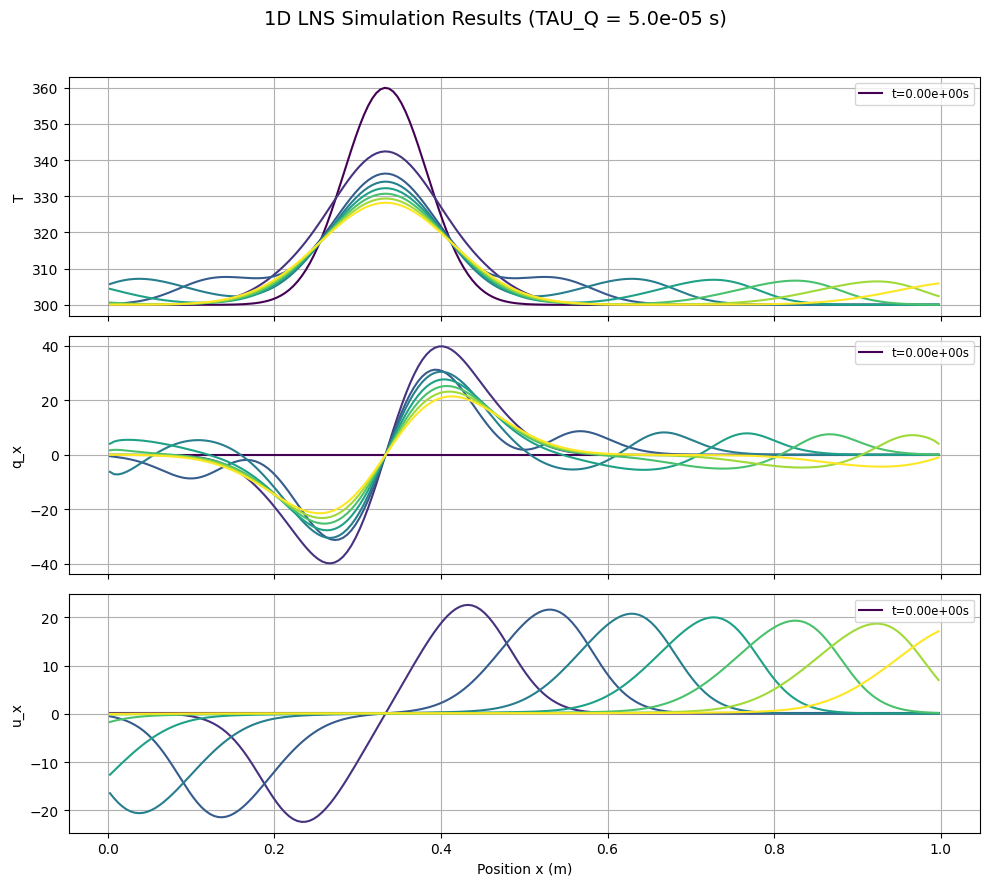

In [6]:
# --- Test Case: Thermal Pulse ---
N = 200
L = 1.0
T_FINAL_SIM = 0.002 # Shorter time for initial tests
CFL = 0.5

# Adjust LNS parameters for visibility
K_THERM = 0.1  # Increase thermal conductivity to make heat transport more apparent
TAU_Q   = 5e-5 # A moderate relaxation time. Try varying this!
               # If too large, q_x won't respond to dT/dx much within T_FINAL_SIM
               # If too small, source term becomes stiff and requires small dt or implicit treatment.

def initial_condition_thermal_pulse(x, L_domain):
    rho0 = 1.0
    u0 = 0.1 # Small background velocity to see advection of q_x field itself
    T0 = 300.0
    p0 = rho0 * R_GAS * T0
    q0 = 0.0 # Initially no heat flux
    
    # Gaussian temperature pulse
    pulse_center = L_domain / 3.0
    pulse_width = L_domain / 20.0
    pulse_amplitude = 60.0 # K
    T_profile = T0 + pulse_amplitude * np.exp(-((x - pulse_center)**2) / (2 * pulse_width**2))
    p_profile = rho0 * R_GAS * T_profile # Adjust pressure to be consistent with T, keeping rho constant initially
    
    return P_and_q_to_Q_1D(rho0, u0, p_profile, T_profile, q0)

print(f"Starting 1D LNS simulation for thermal pulse (TAU_Q = {TAU_Q:.1e})...")
x_sim, t_hist_sim, Q_hist_sim = solve_1D_LNS_FVM(N, L, T_FINAL_SIM, CFL, 
                                                initial_condition_thermal_pulse, 
                                                bc_type='outflow') # or 'periodic'
print("Simulation finished.")

# --- Plotting ---
def plot_1D_LNS_results(x_coords, time_points, Q_history, vars_to_plot=['T', 'q_x'], plot_interval=5):
    num_time_steps_to_plot = (len(time_points) -1) // plot_interval + 1
    if num_time_steps_to_plot == 0 and len(time_points)>0: num_time_steps_to_plot = 1
    if num_time_steps_to_plot == 0: 
        print("No history to plot.")
        return
        
    num_vars_plot = len(vars_to_plot)
    fig, axes = plt.subplots(num_vars_plot, 1, figsize=(10, 3 * num_vars_plot), sharex=True, squeeze=False)
    
    plot_colors = plt.cm.viridis(np.linspace(0, 1, num_time_steps_to_plot))

    plot_counter = 0
    for k_snapshot, time_idx in enumerate(range(0, len(time_points), plot_interval)):
        Q_snap = Q_history[time_idx]
        P_snap_rho = np.zeros(N)
        P_snap_ux  = np.zeros(N)
        P_snap_p   = np.zeros(N)
        P_snap_T   = np.zeros(N)
        Q_snap_qx  = Q_snap[:,3] # q_x is directly in Q

        for i in range(Q_snap.shape[0]):
            P_vals = Q_to_P_1D(Q_snap[i,:])
            P_snap_rho[i] = P_vals[0]
            P_snap_ux[i]  = P_vals[1]
            P_snap_p[i]   = P_vals[2]
            P_snap_T[i]   = P_vals[3]
            
        data_map = {'rho': P_snap_rho, 'u_x': P_snap_ux, 'p': P_snap_p, 'T': P_snap_T, 'q_x': Q_snap_qx}
        color_idx = plot_counter % len(plot_colors)

        for i_var, var_name in enumerate(vars_to_plot):
            axes[i_var, 0].plot(x_coords, data_map[var_name], label=f't={time_points[time_idx]:.2e}s', color=plot_colors[color_idx])
            axes[i_var, 0].set_ylabel(var_name)
            if k_snapshot == 0 : # Add legend only once per subplot or adjust
                 axes[i_var, 0].legend(fontsize='small', loc='upper right')
            axes[i_var, 0].grid(True)
        plot_counter +=1
            
    axes[-1, 0].set_xlabel('Position x (m)')
    fig.suptitle(f'1D LNS Simulation Results (TAU_Q = {TAU_Q:.1e} s)', fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
    plt.show()

if Q_hist_sim:
    plot_1D_LNS_results(x_sim, t_hist_sim, Q_hist_sim, vars_to_plot=['T', 'q_x', 'u_x'], plot_interval=max(1, len(t_hist_sim)//6))
else:
    print("Simulation history is empty, skipping plot.")

## 4. Analysis and Next Steps

**Analysis of Results:**
*   Observe the propagation of the thermal pulse. Does it behave like a wave or more like diffusion? How does changing $\tau_q$ affect this? (A very diffusive scheme like Lax-Friedrichs might smear sharp wave fronts).
*   Look at the $q_x$ profile. Does it build up and relax as expected based on the temperature gradient and $\tau_q$?
*   Check for numerical stability and any unphysical oscillations.

**Limitations of this Implementation:**
*   **Numerical Scheme:** Lax-Friedrichs is highly diffusive. For accurate wave propagation and turbulence, higher-order schemes (e.g., MUSCL with slope limiters, WENO) and better Riemann solvers (HLLC, Roe) are essential.
*   **Source Term Stiffness:** If $\tau_q$ is very small, the source term for $q_x$ becomes stiff, requiring very small $\Delta t$ for explicit stability. Implicit or semi-implicit treatment of source terms (e.g., via operator splitting) would be more robust.
*   **Simplified Physics:** We omitted dynamic viscous stresses and used a simplified 1D objective derivative for $q_x$. A full LNS system is more complex.
*   **Boundary Conditions:** Only simple periodic or outflow BCs were implemented.

**Next Steps in the Series (Conceptual):**
*   **Notebook 2 (Actual):** Would involve extending this to 2D, which significantly complicates the flux and source term calculations (especially the objective derivatives for stress tensor components).
*   **Notebook 3 (Actual):** Would apply the 2D LNS solver to instability problems like Kelvin-Helmholtz and start introducing basic turbulence metrics.
*   **Notebook 4 (Actual):** Would discuss more advanced turbulence simulations (e.g., DHIT), analysis of intermittency, and the potential of LNS for subgrid-scale modeling, assuming a more mature LNS solver.